# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
# !pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
os_file = 'Reacher_Windows_x86_64/Reacher.exe'
# os_file = 'Reacher_Linux/Reacher.x86_64' # 'Reacher_Linux_NoVis/Reacher.x86_64'
env = UnityEnvironment(file_name=os_file)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
# size of each action
action_size = brain.vector_action_space_size
# size of the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('action description: ',brain.vector_action_descriptions)
print('vector_observations have shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('States is type: ',type(states))

Number of agents: 20
Size of each action: 4
action description:  ['', '', '', '']
vector_observations have shape:  (20, 33)
There are 20 agents. Each observes a state with length: 33
States is type:  <class 'numpy.ndarray'>


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [7]:
import time
import numpy as np
# keep track of how long training takes
# widget bar to display progress
#!pip install progressbar
import matplotlib.pyplot as plt
import progressbar as pb
import torch
import torch.optim as optim
import torch.nn as nn
from ACnets import Policy, Critic

# Get device available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)


using device:  cpu


When finished, you can close the environment.

In [8]:
def get_samples(env, policy, critic, train_mode=True):
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=train_mode)[brain_name]     # reset the environment    
    # get the current state (for each agent)
    states = env_info.vector_observations 
    # initialize containers
    scores = np.zeros(num_agents)                          
    States, LogPs, Actions, Rewards, Vs = [], [], [], [], []
    #loop until episode is done
    while True:
        states = torch.tensor(states,dtype=torch.float,device=device)
        log_Ps, actions = policy(states)
        #actions = mu_actions + noise*np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = actions.cpu().detach().numpy()
        a = np.clip(actions, -1, 1) # all actions between -1 and 1
        env_info = env.step(a)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        s_vals = critic(states).cpu().detach().numpy()     # get state value
        #add info to episode lists
        States.append(states.cpu().detach().numpy())
        LogPs.append(log_Ps.cpu().detach().numpy())
        Actions.append(actions)
        Rewards.append(np.array(rewards))
        Vs.append(s_vals)
        #perform step
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    States = np.asarray(States)
    LogPs = np.asarray(LogPs)
    Actions = np.asarray(Actions)
    Rewards = np.asarray(Rewards)
    Vs = np.squeeze(np.asarray(Vs))
    return States, LogPs, Actions, Rewards, Vs, scores

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
def norm_returns(rewards, discount):
    discouted_rewards =  np.asarray([rewards[i]*discount**i for i in range(len(rewards))],dtype=np.float32)
    #convert to future rewards
    future_rewards = np.cumsum(discouted_rewards[::-1],axis=0)[::-1]
    returns = future_rewards.copy()
    #normalize rewards
#     mu = np.mean(future_rewards,axis=1)
#     stdv = np.std(future_rewards,axis=1) + 1.e-10
#     returns = (future_rewards - mu[:,np.newaxis])/stdv[:,np.newaxis]
#     print(returns.shape)
    return returns

def advantage_estimate(rewards, discount, Vs, lmda):
    V_next = np.concatenate((Vs[1:],np.zeros(Vs[0].shape)[np.newaxis]),axis=0)
    TD_error = rewards + discount*V_next - Vs
    truncation_weights = [[(discount*lmda)**i] for i in range(len(rewards))]
    advantage = [np.sum(TD_error[i:]*truncation_weights[::-1][i:][::-1],axis=0) for i in range(len(rewards))]
    advantage = np.asarray(advantage)
    return advantage

def PPO(policy, states, log_ps, actions, advantage, epsilon=0.1, debug=False):
    if debug:
        print(states.shape, actions.shape)

    # convert states to policy
    new_logPs, _ = policy(states, actions)
    #compute probabilities ratio = new_probs/old_probs
    Delta = new_logPs - log_ps
    ratio = torch.exp(Delta)
    if debug:
        print(ratio)
        print(Delta)

    #compute returns and clipped function
    min_ratio = torch.min(advantage*ratio, advantage*torch.clamp(ratio, 1-epsilon, 1+epsilon))
    
    return -torch.mean(min_ratio)

def Lcritic(critic, states, returns_estimation):
    # convert states to value
    values = critic(states).view(-1)
    return torch.nn.functional.mse_loss(returns_estimation, values)

def get_minibatches(data_size, batch_size, suffle=True):
    indices = np.arange(data_size)
    if suffle:
        np.random.shuffle(indices)
    for mb in range(0,data_size-batch_size + 1, batch_size):
        get_indx = indices[mb:mb+batch_size]
        yield get_indx

In [10]:
# initialize actor and critic 
policy = Policy(state_size, action_size).to(device)
critic = Critic(state_size).to(device)

Actor has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256  action_size 4
Critic has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256


In [12]:
States, LogPs, Actions, Rewards, Vs, scores = get_samples(env, policy, critic)
print(np.mean(scores))
print(States.shape, LogPs.shape, Actions.shape, Rewards.shape, Vs.shape)

0.19899999555200337
(1001, 20, 33) (1001, 20) (1001, 20, 4) (1001, 20) (1001, 20)


1.3338421750813723 -0.9844527244567871
0.59999996 0.0
(1001, 20) (1001, 20)


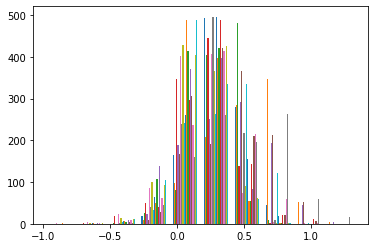

In [13]:
discount, lmda = 1,1
Adv = advantage_estimate(Rewards, discount, Vs, lmda)
print(Adv.max(),Adv.min())
Ret = norm_returns(Rewards, discount)
print(Ret.max(),Ret.min())
print(Adv.shape,Ret.shape)
plt.figure()
plt.hist(Adv)
plt.show()

In [14]:
States = torch.tensor(States, dtype=torch.float, device=device).view(-1,States.shape[-1])
Adv = torch.tensor(Adv, dtype=torch.float, device=device).view(-1)
Actions = torch.tensor(Actions, dtype=torch.float, device=device).view(-1,Actions.shape[-1])
LogPs = torch.tensor(LogPs, dtype=torch.float, device=device).view(-1)

loss = PPO(policy, States, LogPs, Actions, Adv, epsilon=0.2, debug=True)

torch.Size([20020, 33]) torch.Size([20020, 4])
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<ExpBackward>)
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         0.0000e+00, -4.7684e-07], grad_fn=<SubBackward0>)


In [17]:
#When working in udacity's workspace, avoid sleeping:
#from workspace_utils import keep_awake --> keep_awake(range(episode))

from collections import deque

def train(envs, policy, critic, episode, lr_act=4e-4, lr_crit=6e-4, discount=.99, lmda=0.95,
          epsilon=0.2, SGD_epoch=10, batch_size=64):
    
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=episode).start()
    
    optimizer = optim.Adam(policy.parameters(), lr=lr_act)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_crit)

    # keep track of progress
    mean_rewards = []
    scores_window = deque(maxlen=100)  # last 100 scores
    ploss = []
    closs = []

    for e in range(episode):

        # collect trajectories
        States, LogPs, Actions, Rewards, Vs, scores = get_samples(envs, policy, critic)
        # return estimation 
        returns_estimation = norm_returns(Rewards, discount)
        #get advantage estimation
        advantage = advantage_estimate(Rewards, discount, Vs, lmda)
        #normalize advantage
        advantage = (advantage - np.mean(advantage))/(np.std(advantage)+1.e-10) 

        total_rewards = np.sum(Rewards, axis=0)

        #transform to tensors and flatten: States, LogPs, Actions, advantage,returns_estimation
        States = torch.tensor(States, dtype=torch.float, device=device).view(-1,States.shape[-1])
        returns_estimation = torch.tensor(returns_estimation, dtype=torch.float, device=device).view(-1)
        advantage = torch.tensor(advantage, dtype=torch.float, device=device).view(-1)
        Actions = torch.tensor(Actions, dtype=torch.float, device=device).view(-1,Actions.shape[-1])
        LogPs = torch.tensor(LogPs, dtype=torch.float, device=device).view(-1)

        # gradient ascent step
        for _ in range(SGD_epoch):
            
            for minibatch in get_minibatches(len(States), batch_size):
                states, log_ps, actions, adv = States[minibatch], LogPs[minibatch], Actions[minibatch], advantage[minibatch]
                returns = returns_estimation[minibatch]
#                 print(states.shape, m_act.shape, actions.shape, adv.shape, returns.shape)
                #PPO return function
                policy_loss = PPO(policy, states, log_ps, actions, adv, epsilon=epsilon)
                # Critic loss
                critic_loss = Lcritic(critic, states, returns)
                #update policy
                optimizer.zero_grad()
                policy_loss.backward()
#                 nn.utils.clip_grad_norm_(policy.parameters(), 5)
                optimizer.step()
                #update critic
                critic_optimizer.zero_grad()
                critic_loss.backward()
#                 nn.utils.clip_grad_norm_(critic.parameters(), 5)
                critic_optimizer.step()
                
            policy_loss = PPO(policy, States, LogPs, Actions, advantage, epsilon=epsilon)
            critic_loss = Lcritic(critic, States, returns_estimation)  
            ploss.append(policy_loss.data)
            closs.append(critic_loss.data)
                
            #print(policy_loss.data)
        # the clipping parameter and noise reduces as time goes on
        epsilon*=.999
#         noise *= noise_decay # this reduces exploration in later runs

        # get the average reward of the parallel environments
        score = np.mean(total_rewards)
        mean_rewards.append(score)
        scores_window.append(score)       # save most recent score

        # display some progress every 20 iterations
        if (e+1)%5 ==0 :
            print("Episode: {0:d}, score (averaged over agents): {1:f}".format(e+1,np.mean(total_rewards)))
            print("Policy loss: {} | Critic loss: {}".format(policy_loss.data,critic_loss.data))
        # update progress widget bar
        timer.update(e+1)
        # check if environment is solved and save
        if np.mean(scores_window)>=30: 
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e+1-100, np.mean(scores_window)))
            # Save actor and critic
            torch.save(policy.state_dict(), 'test-Reacher.policy')
            torch.save(critic.state_dict(), 'test-Reacher.critic')
            print('Networks saved')
            break

    timer.finish()
    return mean_rewards, ploss, closs

In [18]:
inputsize, action_size = state_size, action_size
policy = Policy(inputsize, action_size).to(device)
critic = Critic(inputsize).to(device)

Actor has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256  action_size 4
Critic has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256


In [19]:
mean_rewards, ploss, closs = train(env, policy, critic, 25)
# I need to stabilize learning. Possible ways:
#  1. decrease noise_decay (tested 0.98 but maybe a bit smaller) -> not working
#  2. decrease epsilon to 0.1 -> not working
#  3. implement noise learning -> works!
#--- clipping gradient? not necessary, although performance seems to increase a bit




Environment solved in -99 episodes!	Average Score: 0.29
Networks saved


Text(0.5, 1.0, 'Critic loss')

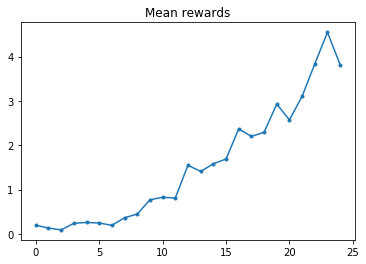

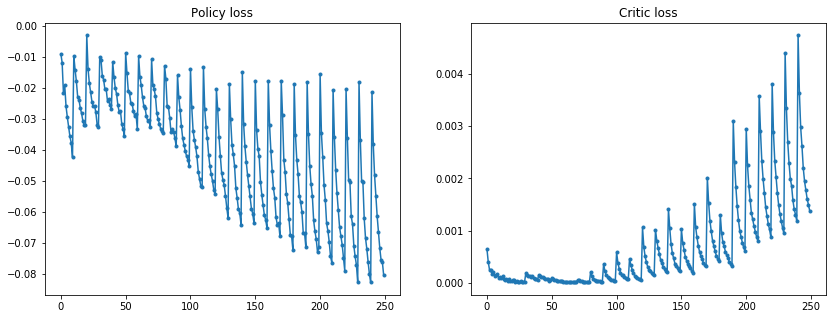

In [36]:
plt.figure()
plt.plot(mean_rewards,'.-')
plt.title("Mean rewards")
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(ploss,'.-')
plt.title("Policy loss")
plt.subplot(122)
plt.plot(closs,'.-')
plt.title("Critic loss")
#[:100]

In [71]:
print([(i, 0.97**i) for i in range(50)])

[(0, 1.0), (1, 0.97), (2, 0.9409), (3, 0.912673), (4, 0.8852928099999999), (5, 0.8587340256999999), (6, 0.8329720049289998), (7, 0.8079828447811298), (8, 0.7837433594376959), (9, 0.7602310586545651), (10, 0.7374241268949281), (11, 0.7153014030880802), (12, 0.6938423609954377), (13, 0.6730270901655746), (14, 0.6528362774606074), (15, 0.6332511891367891), (16, 0.6142536534626855), (17, 0.5958260438588049), (18, 0.5779512625430407), (19, 0.5606127246667495), (20, 0.543794342926747), (21, 0.5274805126389446), (22, 0.5116560972597762), (23, 0.49630641434198286), (24, 0.48141722191172337), (25, 0.4669747052543717), (26, 0.4529654640967405), (27, 0.4393765001738383), (28, 0.42619520516862314), (29, 0.4134093490135644), (30, 0.4010070685431575), (31, 0.38897685648686275), (32, 0.37730755079225686), (33, 0.36598832426848915), (34, 0.35500867454043444), (35, 0.3443584143042214), (36, 0.33402766187509475), (37, 0.3240068320188419), (38, 0.31428662705827665), (39, 0.3048580282465283), (40, 0.29571

In [ ]:
env.close()

In [79]:
import torch.nn as nn
std = nn.Parameter(torch.ones(1, action_size))
print(std)

Parameter containing:
tensor([[1., 1., 1., 1.]], requires_grad=True)


In [55]:
def testfunc(x,*args):
    if len(args)==0:
        print(f'There is only x with value {x}')
    elif len(args)==1:
        print(f'x is {x} and args is {args[0]}')
    else:
        print('Too many arguments, give only one arg extra')
    return x, args

In [56]:
x, y = testfunc(1)
x, y = testfunc(1,3.3333)
x, y = testfunc(x,2*x,6)

There is only x with value 1
x is 1 and args is 3.3333
Too many arguments, give only one arg extra


In [23]:
0.2*(0.999)**50

0.1902411256394063